# Implement LS2

In [29]:
#imports

from importlib import reload

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
from datetime import datetime, time
import random 
import torch

import pandas
import seaborn as sns

from oceancolor.utils import plotting 
from oceancolor.iop import cross
from oceancolor.ls2 import kd_nn
from oceancolor.ls2 import ls2_main
from oceancolor.ls2.io import load_LUT
from oceancolor.water import absorption
from oceancolor.water import scattering
from oceancolor.hydrolight import loisel23

from ihop import io as ihop_io
from ihop.iops import decompose 
from ihop.emulators import io as emu_io
from ihop.inference import io as inf_io
from ihop.training_sets import load_rs

import reconstruct

In [25]:
%matplotlib ipympl

# Load

In [64]:
hidden_list=[512, 512, 512, 256]
dataset='L23' 
chop_burn=-3000 
abs_sig=None # Noiseless
perc=None
X=4 
Y=0 
#in_idx:int=2663  # Min
#in_idx:int=0
in_idx:int=2949 # Max
decomps=('nmf', 'nmf')
Ncomps = (4,2)

In [65]:
# Load
edict = emu_io.set_emulator_dict(dataset, decomps, Ncomps, 'Rrs',
    'dense', hidden_list=hidden_list, include_chl=True, X=X, Y=Y)

ab, Chl, Rs, d_a, d_bb = ihop_io.load_l23_full(decomps, Ncomps)

emulator, e_file = emu_io.load_emulator_from_dict(edict)

chain_file = inf_io.l23_chains_filename(edict, abs_sig) 
d_chains = inf_io.load_chains(chain_file)

Loading... 
Loading decomps from /home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/nmf_L23_X4Y0_a_N04.npz and /home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/nmf_L23_X4Y0_bb_N02.npz
Loading: /home/xavier/Projects/Oceanography/Color/IHOP/Emulators/L23/L23_X4_Y0_nmfnmf_42_chl_Rrs_dense_512_512_512_256.pth
Loading MCMC chains: /home/xavier/Projects/Oceanography/Color/IHOP/Fits/L23/fitN_Rs01_L23_X4_Y0_nmfnmf_42_chl_Rrs_dense_512_512_512_256.npz


In [5]:
wave = d_a['wave']

## Full ds

In [30]:
ds = loisel23.load_ds(4,0)

In [33]:
ds

<xarray.Dataset> Size: 18MB
Dimensions:  (Lambda: 81, IOP_Scenario: 3320)
Coordinates:
  * Lambda   (Lambda) float32 324B 350.0 355.0 360.0 365.0 ... 740.0 745.0 750.0
Dimensions without coordinates: IOP_Scenario
Data variables: (12/17)
    Rrs      (IOP_Scenario, Lambda) float32 1MB 0.01176 0.01201 ... 3.041e-05
    Ed_0+    (IOP_Scenario, Lambda) float32 1MB 0.7753 0.7314 ... 1.237 1.222
    Lw       (IOP_Scenario, Lambda) float32 1MB 0.009118 0.008785 ... 3.716e-05
    Lu_0+    (IOP_Scenario, Lambda) float32 1MB 0.04075 0.03903 ... 0.0624
    a        (IOP_Scenario, Lambda) float32 1MB 0.03096 0.02925 ... 2.83 2.85
    anw      (IOP_Scenario, Lambda) float32 1MB 0.02386 0.02245 ... 0.0004
    ...       ...
    bph      (IOP_Scenario, Lambda) float32 1MB 0.04521 0.04454 ... 0.1008
    bd       (IOP_Scenario, Lambda) float32 1MB 0.03323 0.03239 ... 0.03513
    bb       (IOP_Scenario, Lambda) float32 1MB 0.006968 0.006587 ... 0.001876
    bbnw     (IOP_Scenario, Lambda) float32 1MB 0.00105 0.001028 ... 0.001641
    bbph     (IOP_Scenario, Lambda) float32 1MB 0.0004521 0.0004454 ... 0.001008
    bbd      (IOP_Scenario, Lambda) float32 1MB 0.0005982 0.000583 ... 0.0006324

# $K_d$

## Grab the "MODIS" wavelengths

In [6]:
modis_wvs = [443, 488, 531, 547, 667] # [nm].
#
i_modis = []
for modis_wv in modis_wvs:
    idx = np.argmin(np.abs(wave-modis_wv))
    i_modis.append(idx)

In [7]:
wave[i_modis]

array([445., 490., 530., 545., 665.], dtype=float32)

## Grab $R_{\rm rs}$[MODIS]

In [66]:
Rrs_MODIS = Rs[in_idx, i_modis] * 1e-4
Rrs_MODIS

array([0.0007393, 0.0011495, 0.0017336, 0.0019565, 0.0010321],
      dtype=float32)

## Calculate $K_d$

In [67]:
Kds = []
for iwave in wave:
    Kd = kd_nn.Kd_NN_MODIS(Rrs_MODIS, 0., iwave)
    Kds.append(Kd[0][0])
# array me
Kds = np.array(Kds)

In [51]:
Kds[0:5]

array([0.04243737, 0.04074803, 0.03921239, 0.03781866, 0.0365562 ])

# LS2 time

## LUT

In [39]:
LS2_LUT = load_LUT()

## Water

In [20]:
a_w = absorption.a_water(wave, data='IOCCG')

In [24]:
_, _, b_w = scattering.betasw_ZHH2009(wave, 20., [0], 35.)

### Plots

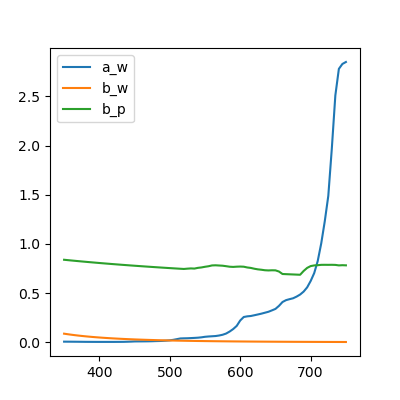

In [70]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
#
ax.plot(wave, a_w, label='a_w')
ax.plot(wave, b_w, label='b_w')
ax.plot(wave, b_p, label='b_p')
#
ax.legend()
#
plt.show()

## $b_p$

In [68]:
b_p = ds.bnw[in_idx, :].data

## Calculate

In [54]:
b_w[0], b_p[0]

(0.088176444, 0.078448)

In [74]:
reload(ls2_main)
sza = 0.
#
all_a = []
all_bb = []
all_bbp = []
all_anw = []
waves = []
for jj, iwave in enumerate(wave):
    #import pdb; pdb.set_trace()
    if iwave < 400.:
        continue
    a, anw, bb, bbp, kappa = ls2_main.LS2_main(sza, iwave, Rs[in_idx, jj]*1e-4, Kds[jj], a_w[jj], b_w[jj], b_p[jj], LS2_LUT, False)
    # Save
    waves.append(iwave)
    all_a.append(a)
    all_anw.append(anw)
    all_bb.append(bb)
    all_bbp.append(bbp)

## Plot

In [73]:
true_a_nw = ds.anw[in_idx, :].data

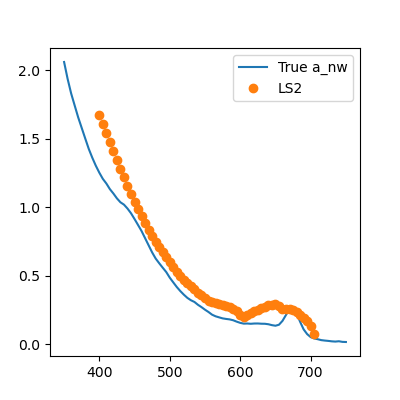

In [76]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
#
ax.plot(wave, true_a_nw, label='True a_nw')
ax.plot(waves, all_anw, 'o', label='LS2')
#
ax.legend()
#
plt.show()